In [13]:
import ray
import numpy as np
import matplotlib.pyplot as plt
from environment import SimpleEnv
from ray.tune.registry import register_env
from ray.rllib.utils.pre_checks.env import check_env
from ray.rllib.algorithms.ppo import PPOConfig

episode: 0
cumulative reward: 71


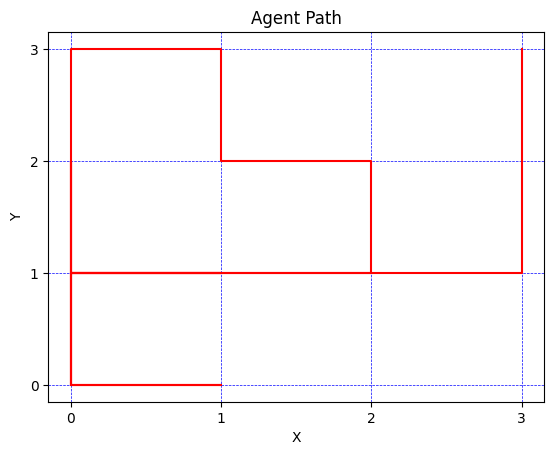

episode: 1
cumulative reward: 72


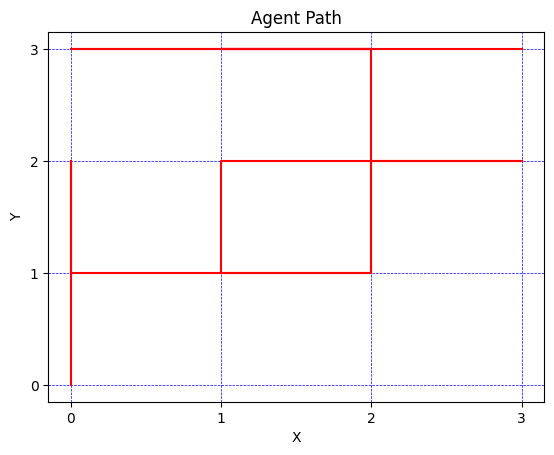

episode: 2
cumulative reward: 12


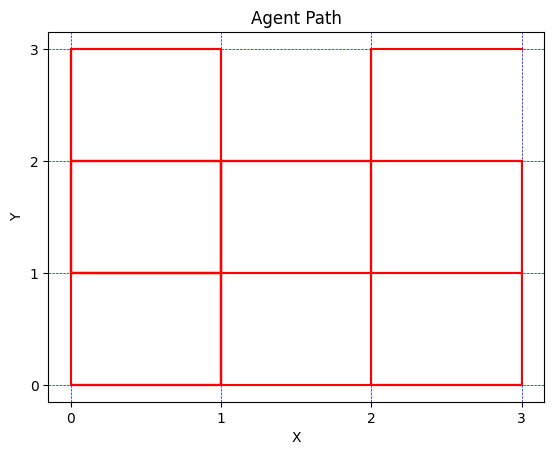

In [2]:
# instantiate the env
length, width, capacity = 4, 4, 2
edge_capacity = np.full((length,width,4),capacity)
env= SimpleEnv(length, width, edge_capacity)
num_episodes = 3

# render the env with random moves
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        total_reward += reward

        if done:
            break

    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [3]:
# register and check the env
register_env("simple_env", lambda config: SimpleEnv(length, width, edge_capacity))

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

2023-10-18 21:37:17,709	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


checking environment ...
All checks passed. No errors found.


In [7]:
# config everything
config = (
    PPOConfig()
    .environment(env = "simple_env")
    .framework(framework="torch")
    .evaluation(
        evaluation_interval=15, 
        evaluation_duration=5,      
        evaluation_num_workers=2,  #0 for Colab
        evaluation_parallel_to_training=True, #False for Colab
        evaluation_config = dict(
            explore=False,
            num_workers=1
        ))
    .rollouts(
    num_rollout_workers=2, #1 for Colab
    num_envs_per_worker=1)
)
algo = config.build()

2023-10-18 21:41:43,605	INFO worker.py:1538 -- Started a local Ray instance.
(raylet) /home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/dashboard/agent.py:51: DeprecationWarning: There is no current event loop
(raylet)   aiogrpc.init_grpc_aio()
(RolloutWorker pid=19186) 2023-10-18 21:41:49,027	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=19290) 2023-10-18 21:41:54,018	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-10-18 21:41:54,256	INFO trainable.py:172 -- Trainable.setup took 12.566 seconds. If your trainable is slow t

In [8]:
# train the policy for 10 iterations, also plot the mean reward vs iteration 
rewards = []
for i in range (10):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])
plt.plot(rewards)
plt.show()

episode: 0
cumulative reward: 95


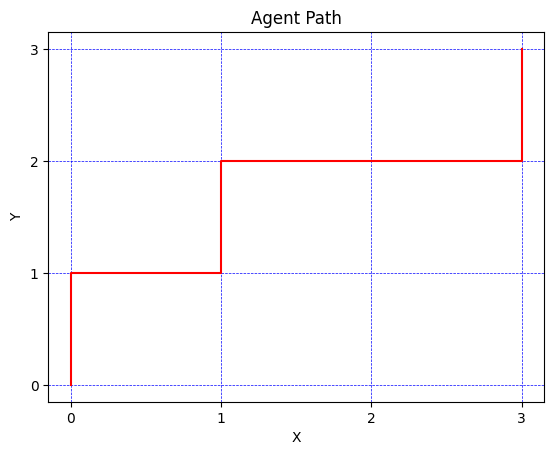

episode: 1
cumulative reward: 95


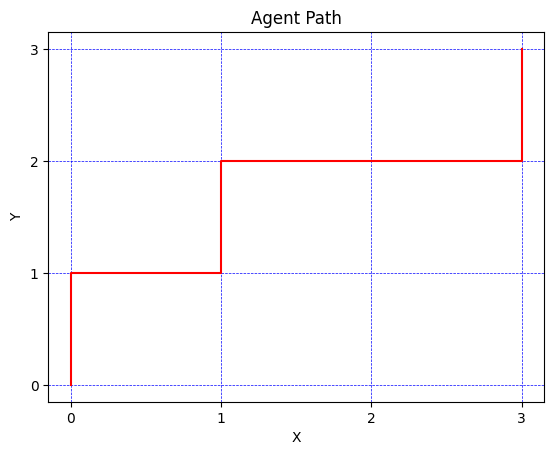

episode: 2
cumulative reward: 95


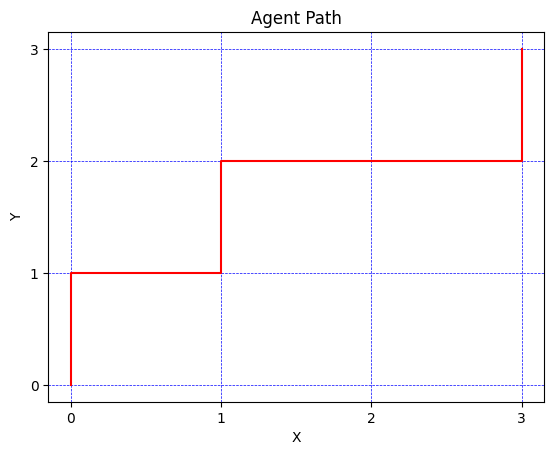

In [9]:
# run inference
num_episodes = 3

for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs, explore=False)
        obs, reward, done, info = env.step(action)
        total_reward += reward
        
        if done:
            break
        
    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [11]:
# release the resources
algo.stop()
ray.shutdown()